Based on the the training data we prepared from [previous notebook](13_prep_training_data_for_fine_tuning.ipynb), in this one, we will attempt to use traditional machine learning methods to predict the pricing of data. 

*Note - This would start with simplest techniquest and will iteratively be updated to get more and more accurate. Best way of learning and experimenting.*

In [1]:
import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
from items import Item

In [7]:
%matplotlib inline

In [8]:
# Loading the pkl files
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [10]:
# Remind a test prompt

print(train[0].price)

226.95


To evaluate different types of models and methods to estimate the pricing, we will have a generic class which can take the `prediction function` which we will pass and run it to provide the results.

In [11]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint) # Call the predictor function with the datapoint
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1) # +1 to avoid log(0)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

Now we attempt different ways to predict the price...

### Model 1: Simple randomn generator to predict the price

In [12]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

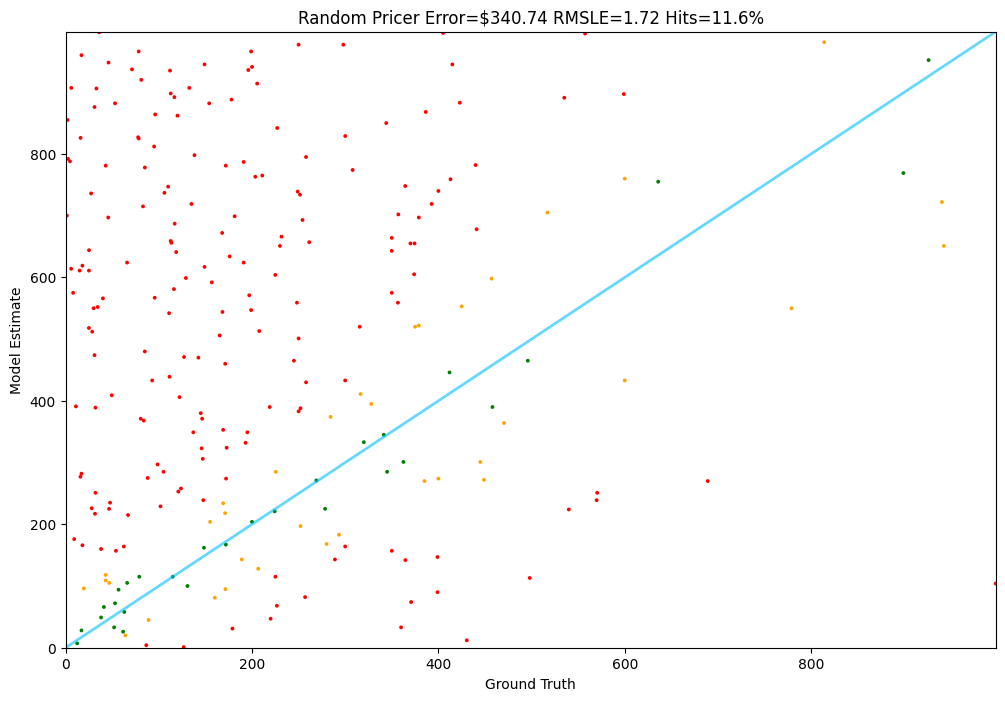

In [13]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

### Model 2: Average of all the prices from training data as our predicted price

In [14]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

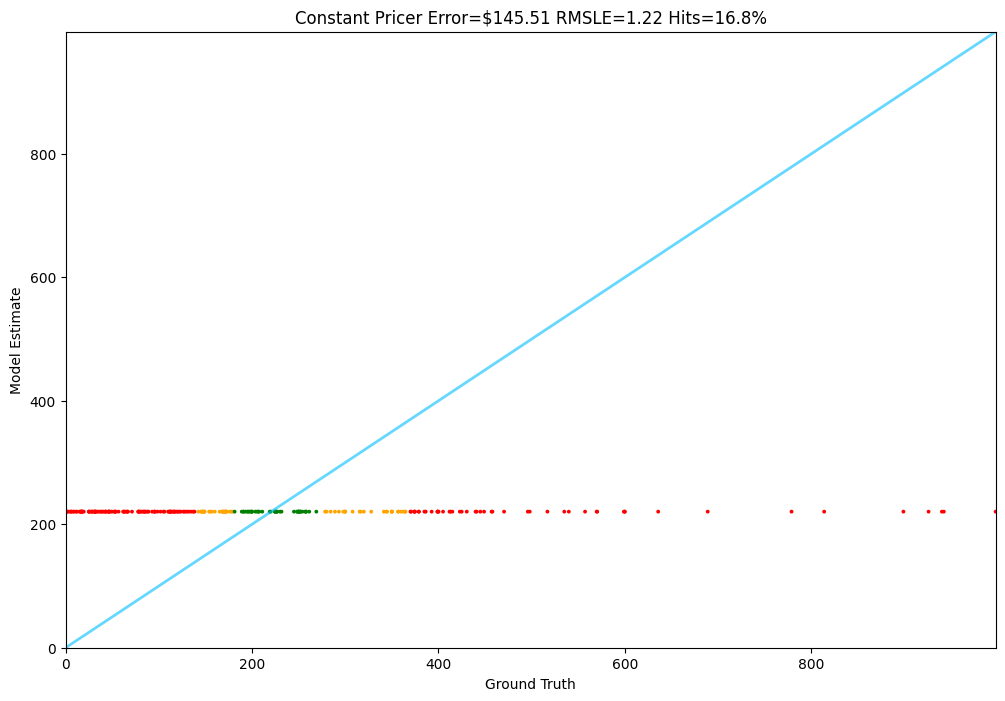

In [15]:
# Run our constant predictor
Tester.test(constant_pricer)

### Let's build and try with some more features 

In [17]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [16]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [18]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [ ]:
# A simpler one-liner to count features

feature_count = Counter([feature for item in train for feature in item.features.keys()])
# for item in train:
#     for f in item.features.keys():
#         feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [20]:
# Normalize all weights to pounds
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [21]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [22]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [23]:
# If a certain item doesn't have a weight, we can assign the average weight
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [24]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [25]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [26]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [27]:
def get_text_length(item):
    return len(item.test_prompt())

In [28]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [29]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [ ]:
# Initial list of features based completely on our gut-feel currently to use for predicting price
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [31]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [32]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

### Model 3 - Traditional `LinearRegression` Model

In [35]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Print the coefficients
# `model.coef_` represents the coefficients (or weights) learned by the linear regression model during training.
# 1. The sign (positive or negative) indicates whether increasing that feature increases or decreases the predicted price
# 2. The absolute value tells you how strongly each feature affects the price prediction
# 3. Larger coefficient values (after standardizing features) suggest more influential predictors
# 4. Each coefficient represents the expected change in price for a one-unit change in the corresponding feature, while holding all other features constant

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")

# Print the intercept
# The intercept is the expected value of the target variable (price) when all features are zero
# 1. It represents the baseline price when all features are at their minimum (zero)
# In practical terms, for this price prediction model, the intercept provides the "default" price that gets adjusted up or down based on the item's specific characteristics. 
# While a scenario where all features equal zero might not be realistic, the intercept is mathematically necessary to properly fit the regression line to the training data.

print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2642321862957332
rank: 5.197480233116737e-05
text_length: 0.0076093283513202605
is_top_electronics_brand: 198.14254283206898
Intercept: 182.18661987897428
Mean Squared Error: 33034.336771967995
R-squared Score: 0.09091571194865222


In [42]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

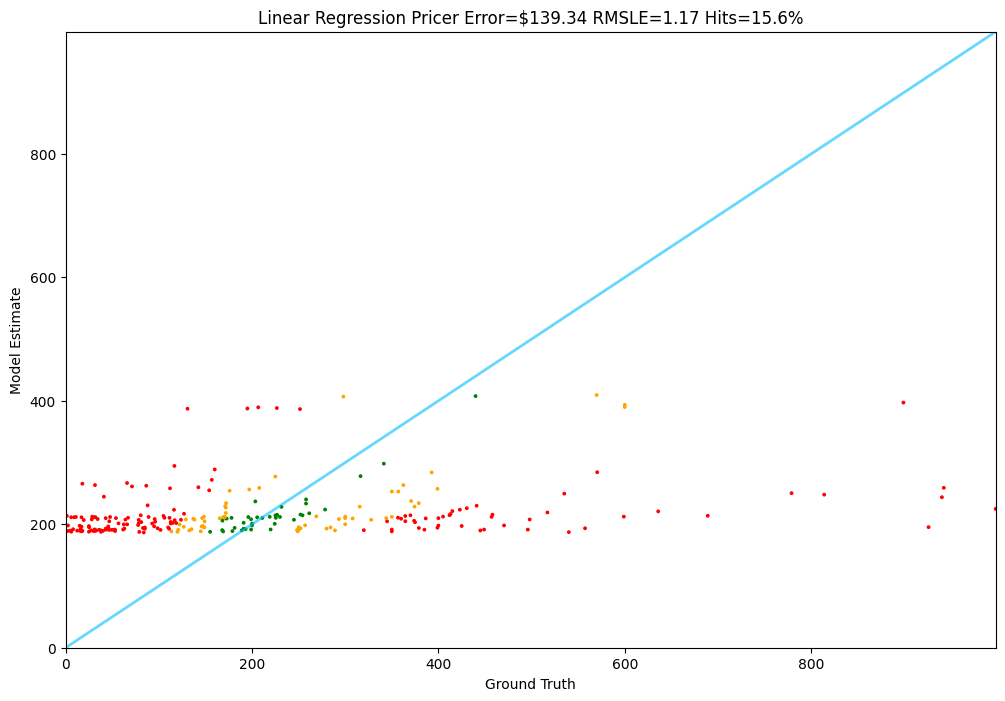

In [43]:
Tester.test(linear_regression_pricer)

### Model 4 - Bag of words

In [51]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [52]:
print(train[0].test_prompt())

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $


Essentially, what we are doing here is predicting the price of the product based on the `test_prompt` we have in the training set (the text which is effectively curated with techniques like `Bag of Words` or `Word2Vec` etc.).

We use the `test_prompt` from the training set and not directly the `prompt` which contains the price. The reason being we need to train the model on prompts which would be familiar when we predict the price from the prompt of test data set - which will _**also**_ not have the price in its prompt.

In [ ]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

Understanding `CountVectorizer`

![alt text](<images/CountVectorizers or Bag of Words Example.png>)

In [ ]:
# This code snippet implements a text-based price prediction model using the Bag of Words approach combined with linear regression.

# Set a specific random seed to ensure reproducible results across multiple runs of the code. 
# This is a good practice in machine learning projects as it allows consistent model behavior.
np.random.seed(42)

# The CountVectorizer is a tool from the sklearn library that converts a collection of text documents into a matrix of token (word) counts.
# 1. It converts product descriptions (stored in documents) into numerical features that machine learning algorithms can process
# 2. Creates a vocabulary of the 1,000 most frequent words removing common English stop words (like "the", "is", etc.) to reduce noise in the data
# 3. It allows the linear regression model to learn relationships between words in product descriptions and their prices
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [46]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.57 Truth: $635.86 Error: $231.29 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.12 Truth: $65.99 Error: $45.13 SLE: 0

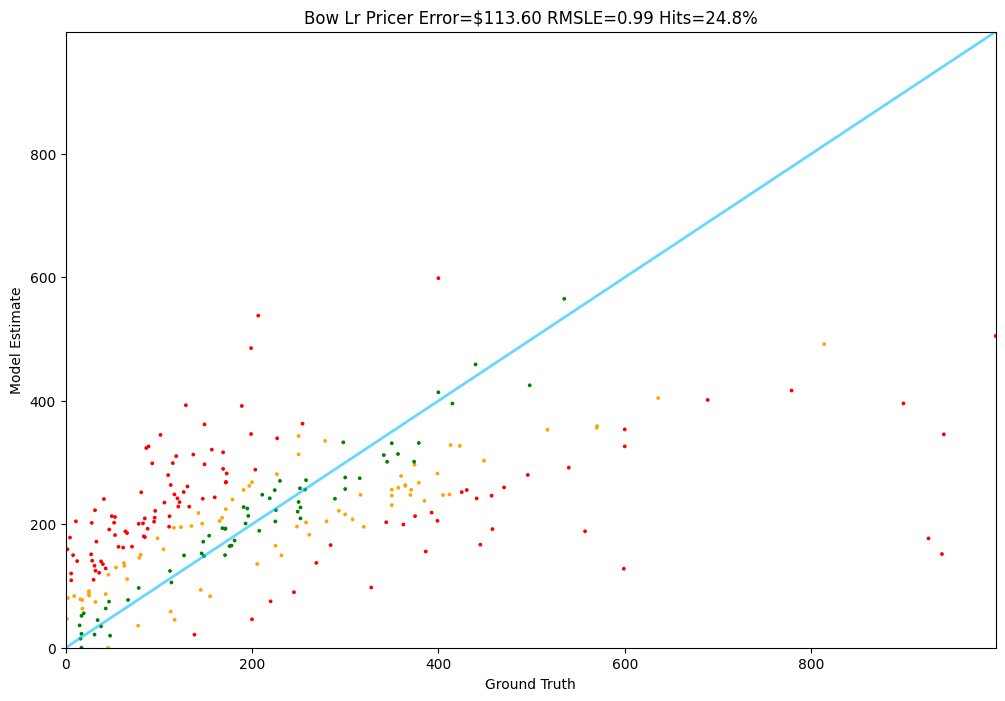

In [47]:
Tester.test(bow_lr_pricer)

### Model 5 - With Word2Vec, implemented in gensim NLP library


In [48]:
np.random.seed(42)

# Preprocess the documents
# The `simple_preprocess` function takes raw text as input and performs several critical transformations:
# 1. Tokenization - It splits the text into individual words or tokens
# 2. Lowercasing - It converts all text to lowercase to ensure consistency
# 3. Punctuation removal - It strips punctuation marks from the text
# 4. Short token filtering - It removes very short words (typically fewer than 2-3 characters)
# 5. Number handling - It can optionally remove numerical values
# `simple_preprocess` is applied to each document in the collection before feeding the data into a Word2Vec model. 
# This preprocessing step is crucial because Word2Vec requires properly tokenized text as input to learn meaningful word embeddings. 
# The function essentially standardizes the text data and eliminates noise that would otherwise interfere with the quality of the word vectors that Word2Vec generates.
processed_docs = [simple_preprocess(doc) for doc in documents]

# 1. The vector_size=400 parameter specifies that each word will be represented as a 400-dimensional vector.
# 2. The window=5 parameter indicates that the model will consider a context window of 5 words on either side when training.
# 3. The min_count=1 parameter means that even words that appear only once in the training data will be included in the vocabulary.
# 4. The workers=8 parameter allows the model to use 8 CPU cores for training, which can speed up the process significantly on multi-core machines.
# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [49]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [53]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [54]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $227.88 Truth: $374.41 Error: $146.53 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $149.18 Truth: $225.11 Error: $75.93 SLE: 0.17 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $158.55 Truth: $61.68 Error: $96.87 SLE: 0.87 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $353.60 Truth: $599.99 Error: $246.39 SLE: 0.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $120.33 Truth: $16.99 Error: $103.34 SLE: 3.64 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $270.50 Truth: $101.79 Error: $168.71 SLE: 0.94 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.95 Truth: $289.00 Error: $26.05 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $335.37 Truth: $635.86 Error: $300.49 SLE: 0.41 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $122.79 Truth: $65.99 Error: $56.80 SLE:

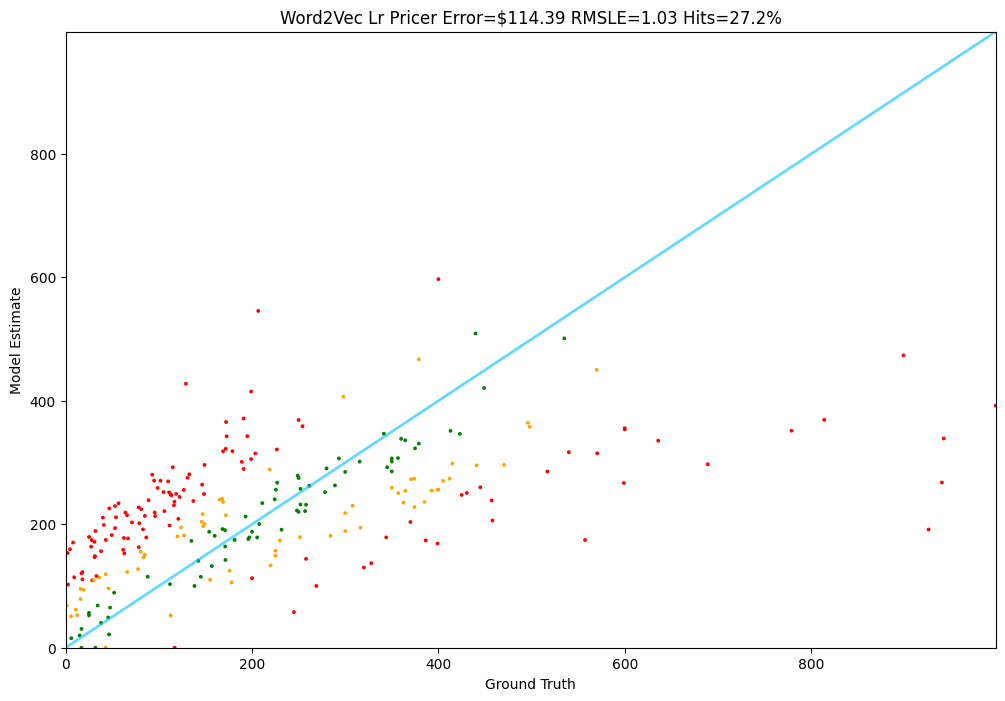

In [55]:
Tester.test(word2vec_lr_pricer)

### Model 5 - Using SVM (Support Vector Machines)

Support Vector Machines (SVMs) are powerful supervised machine learning algorithms used for both classification and regression tasks. In this notebook, a variant called Linear Support Vector Regression (LinearSVR) is being used for price prediction.<br>
<br>
In the price prediction task:

1. Robust to Outliers: Unlike linear regression, SVMs are less influenced by outlier products with unusual pricing

2. Margin-Based Learning: SVMs focus on finding predictions that are within an acceptable error margin from the true prices

3. Effective with High-Dimensional Data: They work well with the 400-dimensional Word2Vec features created from product descriptions

In [56]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [57]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $238.75 Truth: $374.41 Error: $135.66 SLE: 0.20 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $181.19 Truth: $225.11 Error: $43.92 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $139.33 Truth: $61.68 Error: $77.65 SLE: 0.65 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $301.97 Truth: $599.99 Error: $298.02 SLE: 0.47 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $71.66 Truth: $16.99 Error: $54.67 SLE: 1.95 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $233.27 Truth: $101.79 Error: $131.48 SLE: 0.68 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $183.53 Truth: $289.00 Error: $105.47 SLE: 0.20 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $295.99 Truth: $635.86 Error: $339.87 SLE: 0.58 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $96.57 Truth: $65.99 Error: $30.58 SLE: 0

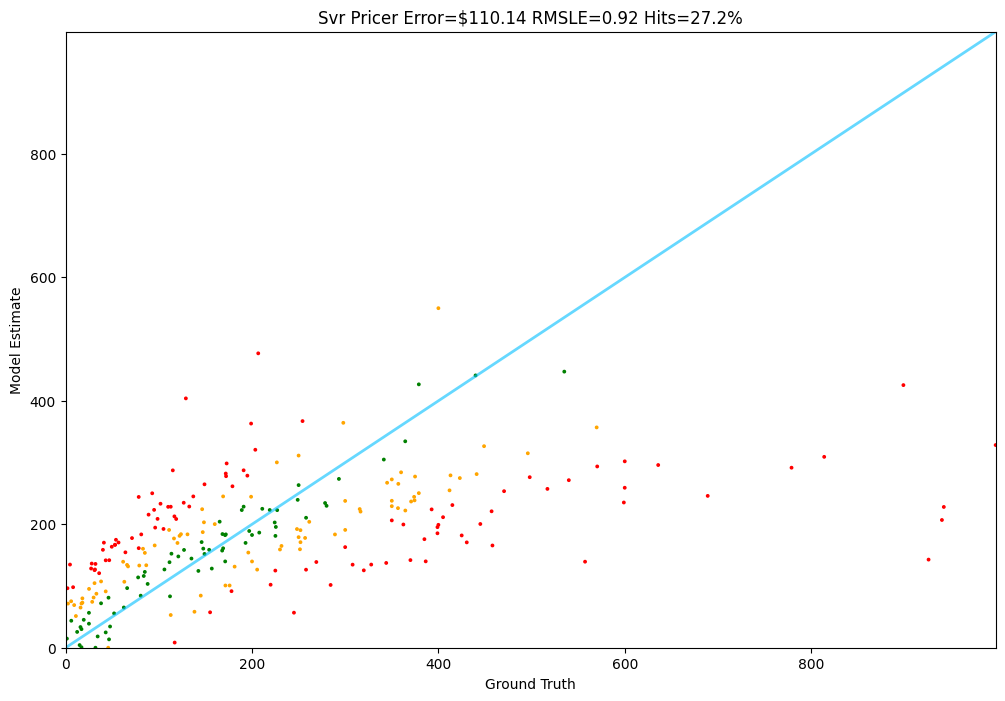

In [58]:
Tester.test(svr_pricer)

### Model 6 - Using Random Forest

Random Forest is an ensemble (group) machine learning algorithm that combines multiple decision trees to produce a more accurate and stable prediction. <br><br>

![alt text](images/random_forest_understanding_example.png)

In the price prediction task:
1. Ensemble Learning: By combining predictions from 100 decision trees, it achieves better accuracy than single models

2. Handles Non-Linear Relationships: Unlike linear regression and SVMs, Random Forest can capture complex, non-linear patterns between product descriptions and prices

3. Works Well with Word Embeddings: It effectively processes the 400-dimensional Word2Vec features without overfitting

4. Parallel Processing: The n_jobs=8 parameter leverages multiple CPU cores for faster training

5. Feature Importance: Though not explicitly shown in the code, Random Forest can reveal which words or concepts most strongly influence product pricing

In [63]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=12)
rf_model.fit(X_w2v, prices)

KeyboardInterrupt: 

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

##### Leveraging Feature Importance with Random Forest
You can extract valuable insights from your trained Random Forest model by analyzing feature importance. Here's how to implement and utilize this concept:

In [ ]:
# Basic Implementation
# After training your Random Forest model
feature_importances = rf_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importances[:20], align='center')
plt.yticks(range(20), [f"Feature {i}" for i in range(20)])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance')
plt.tight_layout()
plt.show()

##### For Word2Vec Features (Advanced)
Since you're using Word2Vec embeddings, each feature doesn't directly correspond to a word. To make feature importance more interpretable:

In [ ]:
# Extract word importance from the model
def get_word_importance():
    # Get words in the vocabulary
    words = list(w2v_model.wv.index_to_key)
    
    # Initialize word importance dictionary
    word_importance = {}
    
    # For each word, calculate its contribution to important features
    for word in words:
        # Get the word vector
        word_vec = w2v_model.wv[word]
        
        # Calculate importance score by multiplying vector elements by feature importance
        importance = sum(word_vec[i] * feature_importances[i] for i in range(len(word_vec)))
        word_importance[word] = importance
    
    return word_importance

# Get and display most important words
word_importance = get_word_importance()
top_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:30]

# Plot top words
plt.figure(figsize=(12, 10))
words, scores = zip(*top_words)
plt.barh(range(len(words)), [abs(score) for score in scores], align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Word Importance')
plt.title('Top Words by Feature Importance')
plt.tight_layout()
plt.show()